In [8]:
# %pip install kagglehub
# %pip install monai
# %pip install ipywidgets
# %pip install pillow tensorflow scikit-learn
# %pip install opencv-python

In [1]:
import os
import numpy as np

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from monai.transforms import ScaleIntensity
import kagglehub

#### Download latest version https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data

In [2]:
path = kagglehub.dataset_download(r"navoneel/brain-mri-images-for-brain-tumor-detection")
# print("Path to dataset files:", path)

#### Paths

In [3]:
dataset_path = f'{path}/brain_tumor_dataset/'
validation_path_yes = f'{path}/yes'
validation_path_no = f'{path}/no'

#### Check data

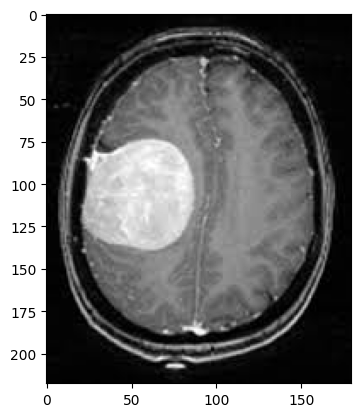

In [4]:
mri_image = cv2.imread(f'{dataset_path}yes/Y1.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(mri_image, cmap='gray')

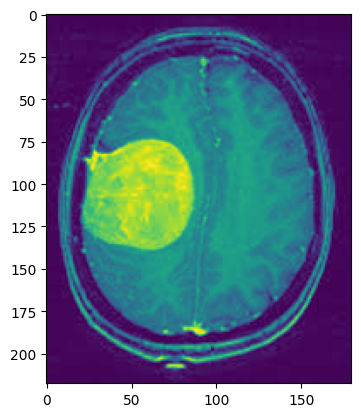

In [5]:
transform = ScaleIntensity(minv=0.0, maxv=1.0)
mri_image_scaled = transform(mri_image)
colored_mri = cm.viridis(mri_image_scaled)
plt.imshow(colored_mri)

#### Load and preprocess images

In [6]:
img_size = (128, 128)
categories = ['no', 'yes']

In [7]:
data = []
labels = []

for label, category in enumerate(categories):
    folder_path = os.path.join(dataset_path, category)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize(img_size)
            img_array = img_to_array(img) / 255.0
            data.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")

#### Convert data and labels to numpy arrays

In [8]:
data = np.array(data)
labels = np.array(labels)

#### Split data into train and test sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

#### Convert labels to one-hot encoded format

In [10]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

#### Build CNN classical model

In [11]:
classical_model = Sequential([
    Input(shape=(img_size[0], img_size[1], 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

#### Compile the model

In [12]:
classical_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Train the model and store the training history

In [13]:
clasical_history = classical_model.fit(
    X_train, 
    y_train, 
    epochs=10, 
    batch_size=32, 
    validation_data=(X_test, y_test)
)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 487ms/step - accuracy: 0.6057 - loss: 0.6749 - val_accuracy: 0.8235 - val_loss: 0.4821
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 415ms/step - accuracy: 0.7332 - loss: 0.5283 - val_accuracy: 0.8235 - val_loss: 0.4061
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 440ms/step - accuracy: 0.7810 - loss: 0.4841 - val_accuracy: 0.8235 - val_loss: 0.4064
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 421ms/step - accuracy: 0.7857 - loss: 0.4591 - val_accuracy: 0.8235 - val_loss: 0.3739
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 426ms/step - accuracy: 0.7627 - loss: 0.4585 - val_accuracy: 0.8431 - val_loss: 0.4166
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step - accuracy: 0.8447 - loss: 0.3915 - val_accuracy: 0.8431 - val_loss: 0.3890
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 460ms/step - accuracy: 0.7657 - loss: 0.4870 - val_accuracy: 0.8039 - val_loss: 0.4237
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 440ms/step - accuracy: 0.8288 - loss: 0.3957 - val_accuracy: 0.9020 - val_loss:

In [14]:
loss, accuracy = classical_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8695 - loss: 0.3784
Test Accuracy: 88.24%
Test Loss: 0.3371


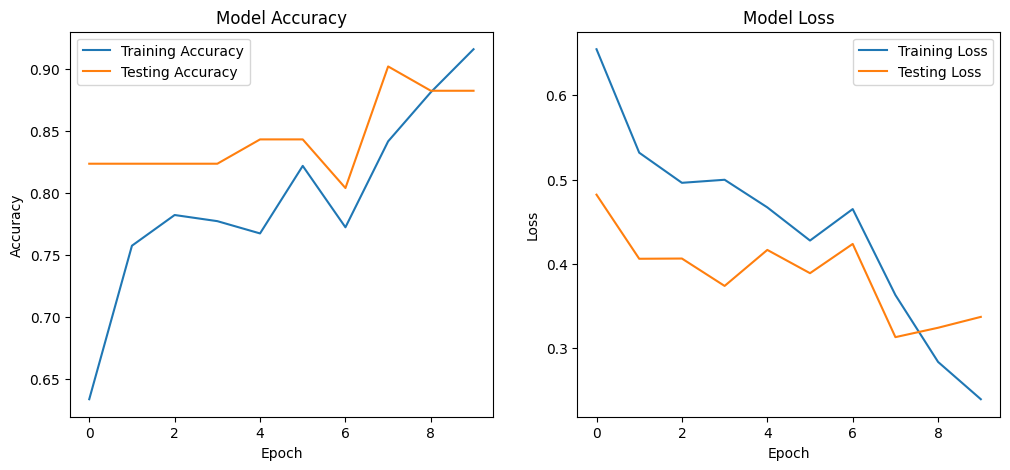

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(clasical_history.history['accuracy'], label='Training Accuracy')
plt.plot(clasical_history.history['val_accuracy'], label='Testing Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(clasical_history.history['loss'], label='Training Loss')
plt.plot(clasical_history.history['val_loss'], label='Testing Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Initialize validation data and labels lists

In [16]:
validation_data = []
validation_labels = []

#### Load and preprocess validation images

In [17]:

for label, folder_path in enumerate([validation_path_no, validation_path_yes]):
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize((128, 128))  # Resize to match the model input
            img_array = img_to_array(img) / 255.0  # Normalize image
            validation_data.append(img_array)
            validation_labels.append(label)  # 0 for 'no', 1 for 'yes'
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")

#### Convert validation data and labels to numpy arrays

In [18]:
validation_data = np.array(validation_data)
validation_labels = np.array(validation_labels)

#### Run predictions on the validation set

In [19]:
predictions = classical_model.predict(validation_data)
predicted_classes = np.argmax(predictions, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


In [20]:
# Calculate accuracy on validation set
accuracy = np.mean(predicted_classes == validation_labels)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Validation Accuracy: 94.07%


### QML

#### Convert labels to one-hot encoded format

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

y_train = np.eye(2)[y_train]
y_test = np.eye(2)[y_test]

#### Define data augmentation for the training dataset

In [22]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.Resize(img_size),
    transforms.ToTensor(),
])

#### Define the QuantumCNN model

In [23]:
class QuantumCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(QuantumCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flattened_size = self._get_flattened_size(img_size[0])

        self.fc1 = nn.Linear(self.flattened_size, 512)  # Increased size of first FC layer
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)  # Output layer
        self.dropout = nn.Dropout(0.5)

    def _get_flattened_size(self, size):
        size = size // 2  # After conv1 and pooling
        size = size // 2  # After conv2 and pooling
        size = size // 2  # After conv3 and pooling
        return 128 * size * size  # 128 channels from conv3

    def forward(self, x):
        x = self.pool(self.bn1(torch.relu(self.conv1(x))))
        x = self.pool(self.bn2(torch.relu(self.conv2(x))))
        x = self.pool(self.bn3(torch.relu(self.conv3(x))))
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Initialize the model, criterion, and optimizer

In [24]:
quantum_model = QuantumCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(quantum_model.parameters(), lr=0.0001)

#### Compute class weights - convert classes to a numpy array

In [25]:
classes = np.array([0, 1])  # Convert list to numpy array
class_weights = compute_class_weight('balanced', classes=classes, y=np.argmax(y_train, axis=1))
class_weights = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights)

#### Training function

In [26]:
def fit_quantum_model(model, X_train, y_train, epochs=30):
    model.train()
    history = {'loss': [], 'accuracy': []}
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Convert training data to tensor and apply augmentation
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor.argmax(dim=1))
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        acc = (predicted == y_train_tensor.argmax(dim=1)).float().mean().item()
        
        # Store metrics
        history['loss'].append(loss.item())
        history['accuracy'].append(acc)

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

    return history

#### Train the quantum model

In [27]:
quantum_history = fit_quantum_model(quantum_model, X_train, y_train, epochs=10)

Epoch [1/10], Loss: 0.6944, Accuracy: 0.5693
Epoch [2/10], Loss: 0.5238, Accuracy: 0.7871
Epoch [3/10], Loss: 0.4553, Accuracy: 0.7624
Epoch [4/10], Loss: 0.3491, Accuracy: 0.8515
Epoch [5/10], Loss: 0.2982, Accuracy: 0.8960
Epoch [6/10], Loss: 0.2335, Accuracy: 0.9604
Epoch [7/10], Loss: 0.1737, Accuracy: 0.9653
Epoch [8/10], Loss: 0.1302, Accuracy: 0.9653
Epoch [9/10], Loss: 0.1052, Accuracy: 0.9802
Epoch [10/10], Loss: 0.0744, Accuracy: 0.9950


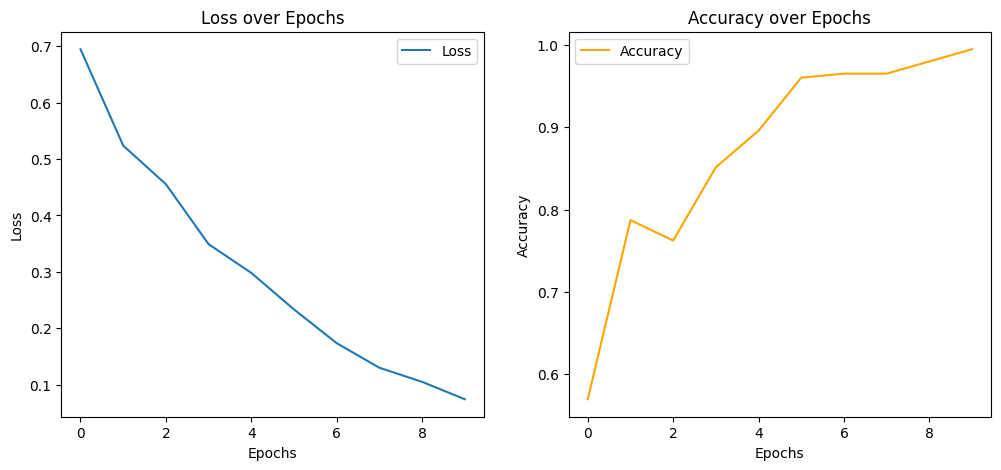

In [28]:
# Step 6: Plotting accuracy and loss
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(quantum_history['loss'], label='Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(quantum_history['accuracy'], label='Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Prepare validation data for prediction

In [29]:
# Validate the model
quantum_validation_data = []
quantum_validation_labels = []

# Load and preprocess validation images
for label, folder_path in enumerate([validation_path_no, validation_path_yes]):
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize(img_size)  # Resize to match the model input
            img_array = np.array(img) / 255.0  # Normalize image
            quantum_validation_data.append(img_array)
            quantum_validation_labels.append(label)  # 0 for 'no', 1 for 'yes'
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")

# Convert validation data and labels to numpy arrays
quantum_validation_data = np.array(quantum_validation_data)
quantum_validation_labels = np.array(quantum_validation_labels)

In [30]:
validation_data_tensor = torch.tensor(quantum_validation_data, dtype=torch.float32).permute(0, 3, 1, 2)  # Shape to (N, C, H, W)

#### Run predictions on the validation set

In [31]:
with torch.no_grad():
    predictions = quantum_model(validation_data_tensor)
    predicted_classes = torch.argmax(predictions, axis=1).numpy()

#### Calculate accuracy on validation set

In [32]:
accuracy = np.mean(predicted_classes == quantum_validation_labels)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 97.23%


In [33]:
print("\nClassification Report:")
print(classification_report(quantum_validation_labels, predicted_classes, target_names=categories))


Classification Report:
              precision    recall  f1-score   support

          no       0.97      0.96      0.96        98
         yes       0.97      0.98      0.98       155

    accuracy                           0.97       253
   macro avg       0.97      0.97      0.97       253
weighted avg       0.97      0.97      0.97       253

